# <a id='toc1_'></a>[__Поиск эффективных локаций размещения рекламных щитов с помощью кластеризации__](#toc0_)

**Содержание**<a id='toc0_'></a>    
- [__Поиск эффективных локаций размещения рекламных щитов с помощью кластеризации__](#toc1_)    
  - [__Теория и примеры__](#toc1_1_)    
  - [__Постановка задачи__](#toc1_2_)    
  - [__Импорты и настройки__](#toc1_3_)    
  - [__Обзор данных__](#toc1_4_)    
  - [__Словарь переменных датасета__](#toc1_5_)    
  - [__Карта чекинов и расположение офисов__](#toc1_6_)    
  - [__Вспомогательные классы и функции__](#toc1_7_)    
  - [__Кластеризация чекинов__](#toc1_8_)    
  - [__Визуализация результатов__](#toc1_9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
## <a id='toc1_1_'></a>[__Теория и примеры__](#toc0_)

[__ml_cluster.ipynb__](https://github.com/EvgenyMeredelin/machine-learning-notes-and-codes/blob/main/ml_cluster/ml_cluster.ipynb), включая kmeans своими руками.

***
## <a id='toc1_2_'></a>[__Постановка задачи__](#toc0_)

Международное круизное агентство Carnival Cruise Line решило разместить 20 рекламных щитов вблизи своих офисов по всему миру. Необходимо выбрать эффективные локации для монтажа щитов.

Логично разместить баннеры в местах интенсивного трафика путешественников. Такие места можно найти по геолокации — по базе чекинов Foursquare. Кластеризуем чекины и найдем популярные места в окрестностях офисов.

***
## <a id='toc1_3_'></a>[__Импорты и настройки__](#toc0_)

In [1]:
# стандартная библиотека
import collections
import bisect
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# сторонние библиотеки
from geopy.distance import geodesic
from mlxtend.plotting import plot_decision_regions
from scipy.spatial.distance import cdist
from sklearn.cluster import MeanShift
import black
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# глобальные настройки графических библиотек
params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(palette='tab10', style='ticks', rc=params)
matplotlib.rcParams['figure.dpi'] = 400

In [4]:
# число рекламных щитов к размещению
N_BANNERS = 20

***
## <a id='toc1_4_'></a>[__Обзор данных__](#toc0_)

In [ ]:
# checkins.csv: https://disk.yandex.com/d/yte0HbQJrGsfTQ

In [6]:
# первые пять строк датасета
df = pd.read_csv('checkins.csv')
df.head()

,id,user_id,venue_id,latitude,longitude,created_at
0,984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
1,984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
2,984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22
3,984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
4,984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18


In [7]:
# полнота данных и типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396634 entries, 0 to 396633
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          396634 non-null  int64  
 1   user_id     396634 non-null  float64
 2   venue_id    396634 non-null  float64
 3   latitude    396634 non-null  float64
 4   longitude   396634 non-null  float64
 5   created_at  396634 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 18.2+ MB


***
## <a id='toc1_5_'></a>[__Словарь переменных датасета__](#toc0_)

* __`id`__ — id наблюдения;
* __`user_id`__ — id пользователя в Foursquare;
* __`venue_id`__ — id места, где произошел чекин (рестораны, достопримечательности и т.п.);
* __`latitude`__, __`longitude`__ — координаты чекина;
* __`created_at`__ — время чекина.

***
## <a id='toc1_6_'></a>[__Карта чекинов и расположение офисов__](#toc0_)

In [8]:
# порядок (долгота, широта) удобнее для визуализаций
X = df[['longitude', 'latitude']].values

In [9]:
# города присутствия компании
cities = [
    'Los Angeles', 'Miami', 'London', 
    'Amsterdam', 'Beijing', 'Sydney'
]

# соответствующие городам координаты офисов компании (долгота, широта)
offices_coords = np.array([[-118.188740, 33.751277], 
                           [-80.324116, 25.867736], 
                           [-0.075479, 51.503016],
                           [4.885084, 52.378894], 
                           [117.036146, 39.366487], 
                           [151.205134, -33.868457]])

# словарь город - координаты офиса в городе
offices = dict(zip(cities, offices_coords))

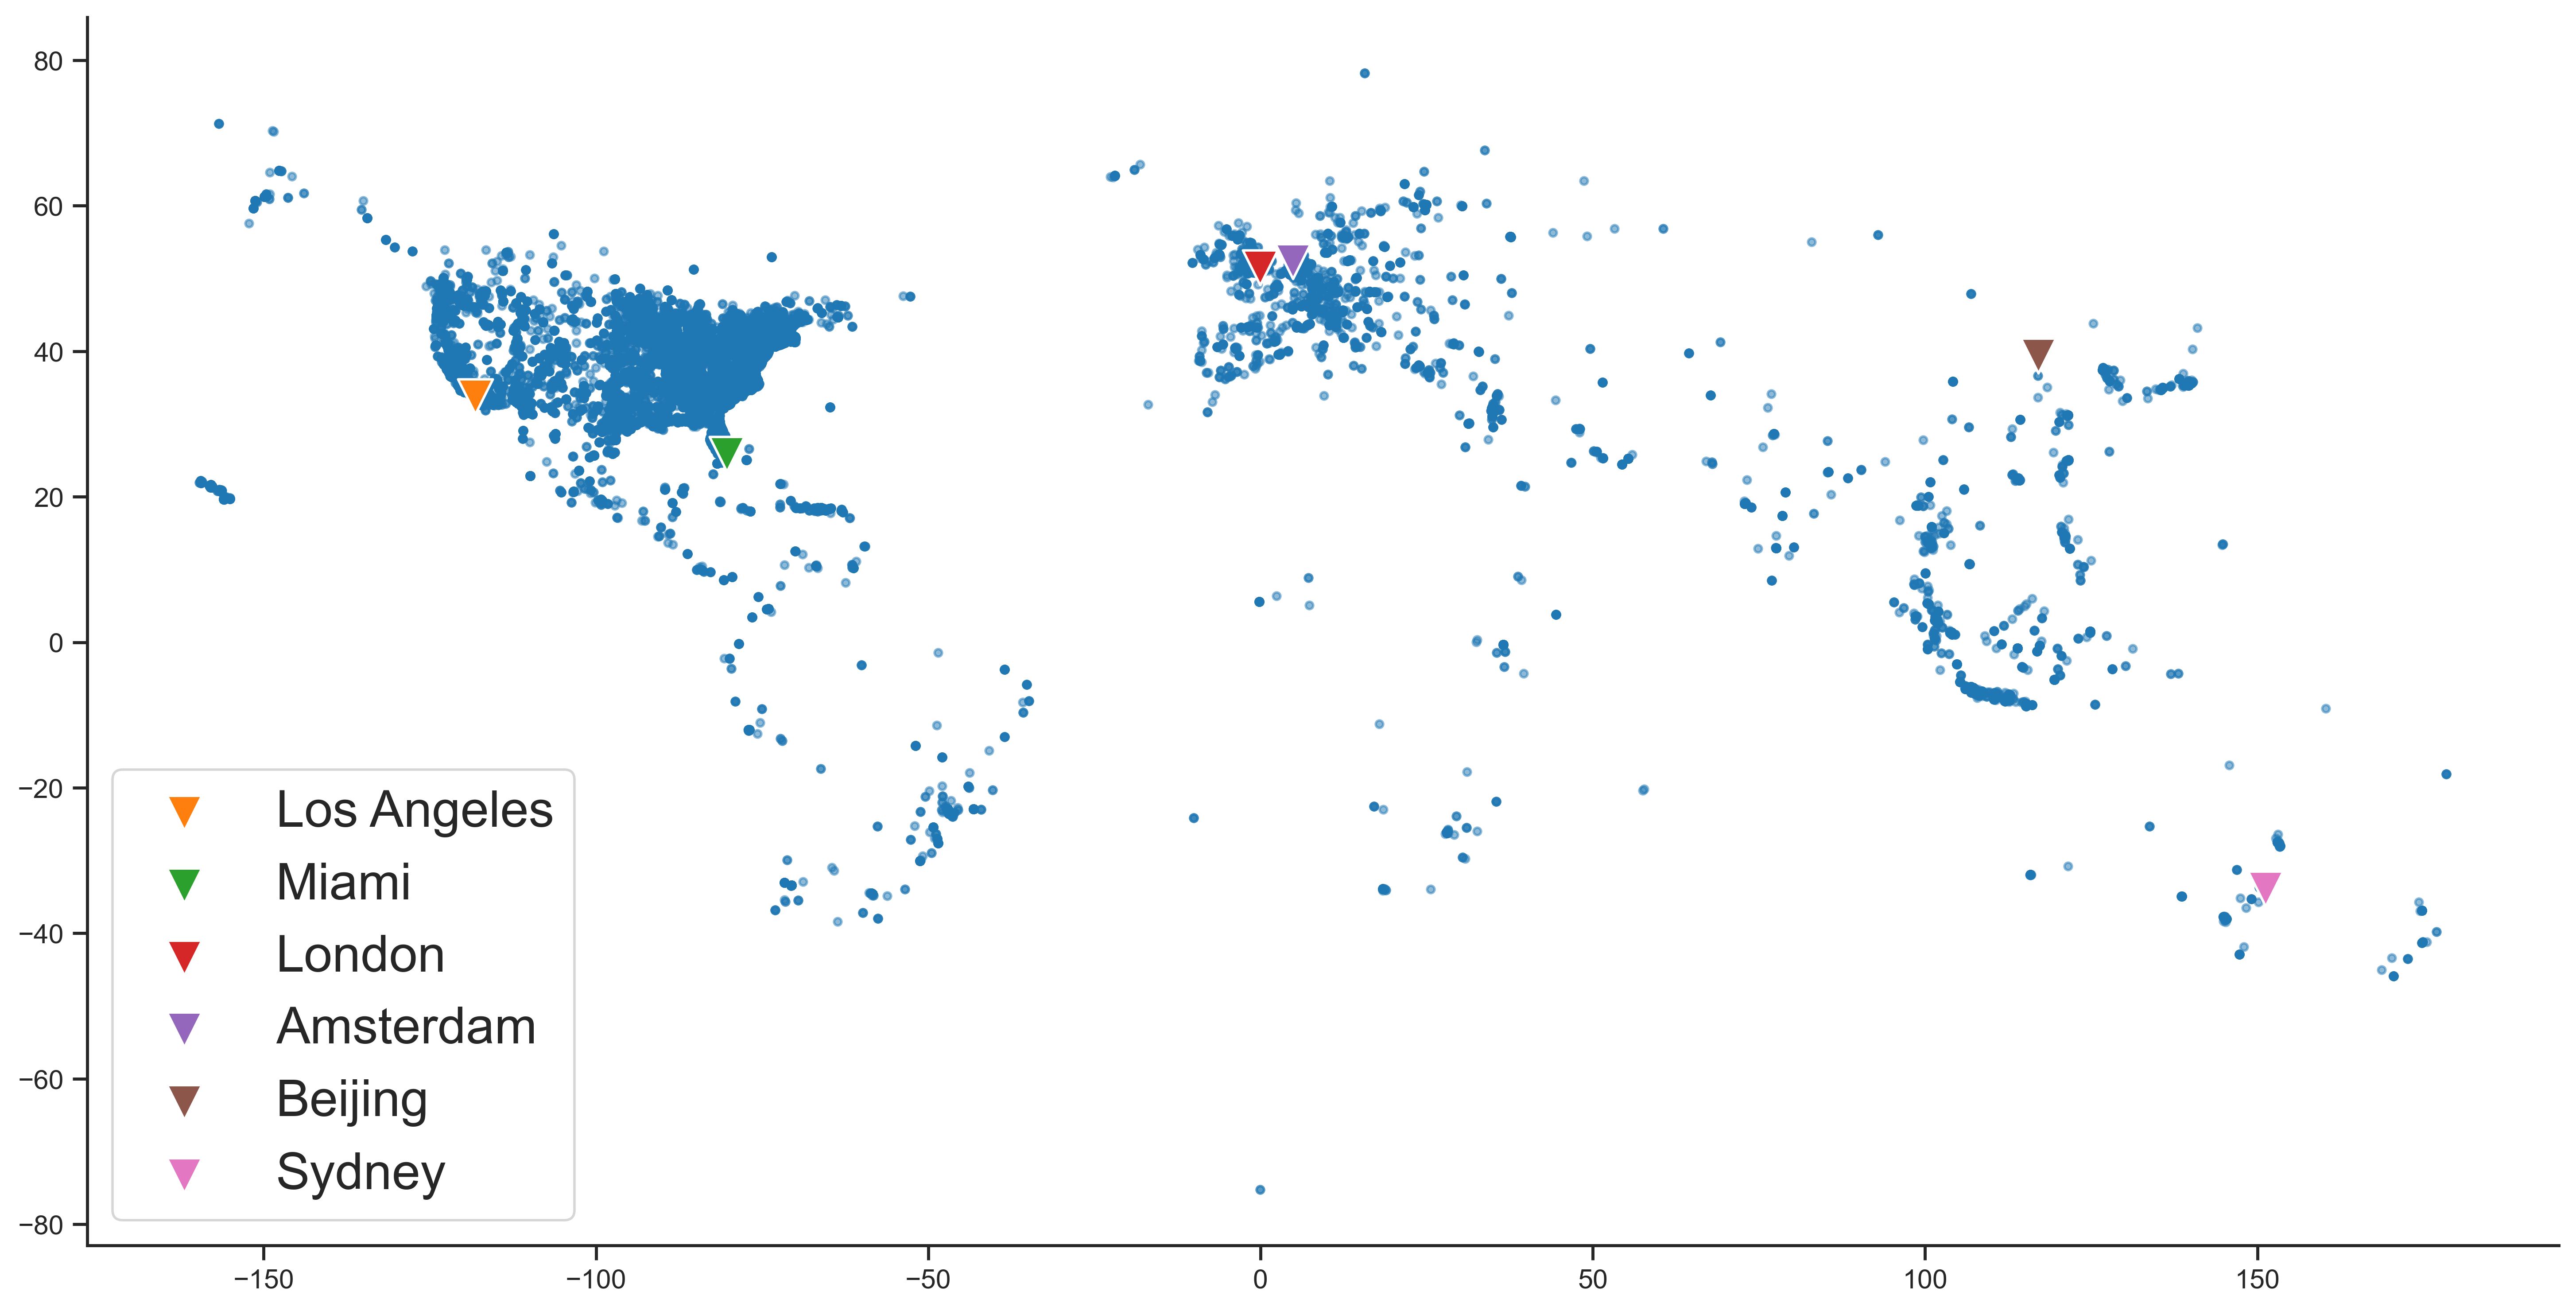

In [10]:
# карта чекинов и расположение офисов
plt.figure(figsize=(18,9))
plt.scatter(X[:,0], X[:,1], marker='.', alpha=0.5)
for city, coords in offices.items():
    plt.scatter(*coords, marker='v', s=200, ec='w', label=city)
plt.legend(loc='lower left', fontsize='xx-large')
plt.show()

***
## <a id='toc1_7_'></a>[__Вспомогательные классы и функции__](#toc0_)

In [11]:
class LowKeeper:
    """
    Список (фильтр) n_slots наименьших значений.
    """
    def __init__(self, n_slots):
        self.n_slots = n_slots
        self.values = []
        
    def update(self, value):
        bisect.insort(self.values, value)
        if len(self.values) > self.n_slots:
            self.values.pop()    
    
    def __repr__(self):
        return black.format_str(str(self.values), mode=black.Mode())
    
    def __len__(self):
        return len(self.values)
    
    def __getitem__(self, index):
        return self.values[index]
    
    def __iter__(self):
        return iter(self.values)

In [12]:
# именованный кортеж, заготовка для наследования
ClusterCenterTuple = collections.namedtuple(
    'ClusterCenterTuple', 
    ['city', 'lonlat', 'distance']
)

In [13]:
class ClusterCenter(ClusterCenterTuple):
    """
    Центр кластера с заданным критерием сравнения.
    """
    def __lt__(self, other):
        return self.distance < other.distance

In [14]:
# обобщающий отчет о кластеризации именованным кортежем
Report = collections.namedtuple(
    'Report', 
    ['city_clustering_checkins', 'banners', 'checkins_total']
)

In [15]:
def km_1degree(latlon):
    """
    Один градус широты в километрах в точке с координатами
    latlon (широта, долгота). 
    """
    return geodesic(latlon, latlon + np.array([1,0])).km

In [16]:
def zoom_in(X, lonlat, radius):
    """
    Чекины из radius-окрестности (в километрах) 
    точки с координатами lonlat (долгота, широта). 
    """
    km = km_1degree(np.flip(lonlat))
    dist = cdist(lonlat.reshape(1,-1), X)[0]
    return X[dist * km <= radius]

***
## <a id='toc1_8_'></a>[__Кластеризация чекинов__](#toc0_)

[__sklearn.cluster.MeanShift__](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn-cluster-meanshift)

> Mean shift clustering using a flat kernel.<br>
Mean shift clustering aims to discover "blobs" in a smooth density of samples. It is a centroid-based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.<br>
Seeding is performed using a binning technique for scalability.

* __`bandwidth`__ регулирует радиус поиска центроида кластера;
* __`bin_seeding=True`__: алгоритм инициализирует начальные точки в местах скопления объектов;
* __`min_bin_freq`__ регулирует минимальное число точек в кластере.

In [17]:
def clustering_report(
    *, radius, n_banners=N_BANNERS, bandwidth=0.1, min_bin_freq=15
):
    """
    Отчет о кластеризации - объект класса Report. 
    """
    # словарь-сборщик данных: ключ - город, значение - кортеж 
    # (кластеризатор MeanShift, чекины в окрестностях офиса в городе)
    city_clustering_checkins = {}
    
    # фильтр двадцати (по умолчанию) ближайших к офису центров кластеров
    banners = LowKeeper(n_banners)
    checkins_total = 0  # счетчик числа чекинов
    
    # для каждого города присутствия и координат офиса в городе
    for city, office_coords in offices.items():        
        # отобрать чекины из radius-окрестности офиса
        checkins = zoom_in(X, office_coords, radius)
        # и определить количество отобранных чекинов
        n_checkins = checkins.shape[0]
        
        # если чекинов заведомо меньше, чем минимально необходимо 
        # для формирования кластера, пропускаем такой офис (Пекин)
        if n_checkins < min_bin_freq:
            continue
        
        # обновление счетчика чекинов
        checkins_total += n_checkins
        
        # инициализация кластеризатора MeanShift
        clustering = MeanShift(
            bandwidth=bandwidth,
            bin_seeding=True,
            min_bin_freq=min_bin_freq
        )        
        clustering.fit(checkins)  # кластеризация отобранных чекинов
        
        # сохранение данных в словаре
        city_clustering_checkins[city] = (clustering, checkins)        
        centers = clustering.cluster_centers_  # центры кластеров
        
        # массив расстояний от офиса до центра каждого кластера
        dists = cdist(office_coords.reshape(1,-1), centers)[0]
        
        # для всех пар (центр кластера, расстояние до него от офиса)
        for center, dist in zip(centers, dists):
            # пересчет расстояния в километры с учетом широты офиса 
            dist_km = dist * km_1degree(np.flip(office_coords))
            # обновление фильтра объектом класса ClusterCenter:
            # центры кластеров, более близкие к офису, вытесняют 
            # более удаленные, оставляя в итоге максимум двадцать 
            # ближайших по всем городам
            banners.update(ClusterCenter(city, center, dist_km))
            
    return Report(city_clustering_checkins, banners, checkins_total)

In [18]:
# настройка: 
# увеличивая радиус сканирования чекинов в окрестностях офиса на единицу, 
# найдем наибольший, при котором число кластеров еще двадцать

radius = range(1, 51)

n_clusters = np.array([
    len(clustering_report(radius=r, n_banners=N_BANNERS + 1).banners) 
    for r in radius
])

n_clusters

array([ 0,  2,  2,  2,  3,  4,  5,  5,  5,  5,  5,  6,  6,  7,  7,  7,  7,
        7,  7,  7,  7,  8,  8,  9,  9,  9, 10, 11, 11, 11, 12, 12, 13, 14,
       14, 14, 14, 14, 16, 17, 19, 19, 19, 19, 20, 21, 21, 21, 21, 21])

In [19]:
# под argmax выражение для общего случая - как если бы двадцатка в n_clusters 
# повторялась более одного раза и нужно было взять индекс последней

optimal_radius = radius[np.argmax(n_clusters > N_BANNERS) - 1]
optimal_radius

45

Это означает, что для того чтобы выбрать двадцать мест монтажа щитов, которыми будут двадцать ближайших к офисам центров кластеров чекинов в окрестностях офисов, при данных параметрах кластеризации достаточно извлекать и кластеризовать чекины из 45-километровых кругов с центрами в офисах компании. Сделаем это и посмотрим на локацию ближайшего к офисам щита:

In [20]:
report = clustering_report(radius=optimal_radius)
report.banners[0]

ClusterCenter(city='Sydney', lonlat=array([151.20708242, -33.86614607]), distance=0.3352511920846323)

Этот щит будет установлен в Сиднее, в 335 метрах (по прямой) от сиднейского офиса компании.

In [21]:
# локации всех двадцати щитов
# report.banners

In [22]:
# полный вывод:

# [
#     ClusterCenter(
#         city="Sydney",
#         lonlat=array([151.20708242, -33.86614607]),
#         distance=0.3352511920846323,
#     ),
#     ClusterCenter(
#         city="Amsterdam",
#         lonlat=array([4.89226825, 52.37248935]),
#         distance=1.0710641642027856,
#     ),
#     ClusterCenter(
#         city="Miami",
#         lonlat=array([-80.29771155, 25.89689645]),
#         distance=4.358470444920677,
#     ),
#     ClusterCenter(
#         city="London",
#         lonlat=array([-0.1271134, 51.50305542]),
#         distance=5.745227393584012,
#     ),
#     ClusterCenter(
#         city="Los Angeles",
#         lonlat=array([-118.14433437, 33.81127536]),
#         distance=8.279984017290111,
#     ),
#     ClusterCenter(
#         city="Miami",
#         lonlat=array([-80.21512757, 25.7870861]),
#         distance=15.021792830107284,
#     ),
#     ClusterCenter(
#         city="Los Angeles",
#         lonlat=array([-118.06740971, 33.87632837]),
#         distance=19.32768944929679,
#     ),
#     ClusterCenter(
#         city="Miami",
#         lonlat=array([-80.20559812, 26.00505198]),
#         distance=20.096813546135152,
#     ),
#     ClusterCenter(
#         city="Los Angeles",
#         lonlat=array([-118.37034494, 33.87201291]),
#         distance=24.19059855546632,
#     ),
#     ClusterCenter(
#         city="Miami",
#         lonlat=array([-80.39255995, 26.11945702]),
#         distance=28.901659546664288,
#     ),
#     ClusterCenter(
#         city="Los Angeles",
#         lonlat=array([-117.89332878, 33.70280018]),
#         distance=33.207345346857494,
#     ),
#     ClusterCenter(
#         city="Los Angeles",
#         lonlat=array([-117.89365104, 33.81172271]),
#         distance=33.412988307821195,
#     ),
#     ClusterCenter(
#         city="Miami",
#         lonlat=array([-80.15977558, 26.12204445]),
#         distance=33.54699206821807,
#     ),
#     ClusterCenter(
#         city="London",
#         lonlat=array([-0.38776673, 51.4855923]),
#         distance=34.8014867430415,
#     ),
#     ClusterCenter(
#         city="Los Angeles",
#         lonlat=array([-118.26547835, 34.06497839]),
#         distance=35.82396542102981,
#     ),
#     ClusterCenter(
#         city="Los Angeles",
#         lonlat=array([-117.97668375, 34.00557767]),
#         distance=36.729498399087014,
#     ),
#     ClusterCenter(
#         city="Amsterdam",
#         lonlat=array([5.09922757, 52.09462001]),
#         distance=39.60665004780155,
#     ),
#     ClusterCenter(
#         city="Los Angeles",
#         lonlat=array([-118.43578389, 34.03351334]),
#         distance=41.60692536231235,
#     ),
#     ClusterCenter(
#         city="Los Angeles",
#         lonlat=array([-118.13351555, 34.1239338]),
#         distance=41.78911489211082,
#     ),
#     ClusterCenter(
#         city="London",
#         lonlat=array([-0.1829137, 51.1133388]),
#         distance=44.97605948376339,
#     ),
# ]

In [23]:
# для нахождения эффективных локаций двадцати щитов 
# потребовалось обработать чуть более 23,5 тыс. чекинов:
report.checkins_total

23510

***
## <a id='toc1_9_'></a>[__Визуализация результатов__](#toc0_)

In [24]:
# настройки отрисовки офисов, центров кластеров и щитов (в центрах кластеров)
office_aes = dict(marker='*', s=500, c='gold', ec='w', alpha=0.8)
center_aes = dict(marker='s', s=90, c='w', ec='k', alpha=0.8)
banner_aes = dict(marker='d', s=90, c='r', ec='k', alpha=0.8)

[__mlxtend.plotting.plot_decision_regions__](https://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/)

In [25]:
def plotter(report: Report) -> None:
    """
    Диаграмма чекинов, кластеров, их центров, щитов и офиса компании.
    """
    # словарь данных из отчета о кластеризации
    ccc = report.city_clustering_checkins
    
    # число строк матрицы диаграмм по числу городов в отчете
    nrows = len(ccc)
    
    # матрица диаграмм
    axs = plt.subplots(nrows=nrows, figsize=(6, nrows * 6))[1]
    it = axs.flat  # итератор осей (ячеек в матрице диаграмм)

    # для каждого города в отчете
    for city, clustering_checkins in ccc.items():
        # извлечь его кластеризатор и чекины
        clustering, checkins = clustering_checkins
        # извлечь центры кластеров
        centers = clustering.cluster_centers_
        # извлечь координаты щитов
        banners = np.array([
            banner.lonlat for banner in report.banners
            if banner.city == city
        ])
        # посчитать число щитов к монтажу
        n_clusters = banners.shape[0]
        ax = next(it)
        
        # отрисовка кластеров закрашенными областями
        plot_decision_regions(
            checkins, clustering.labels_, clustering,
            ax=ax, zoom_factor=10, legend=0
        )
        ax.scatter(*centers.T, **center_aes)  # отрисовка центров кластеров
        ax.scatter(*banners.T, **banner_aes)  # отрисовка рекламных щитов
        ax.scatter(*offices[city], **office_aes)  # отрисовка офисов компании
        
        # заголовок диаграммы с указанием города и числа щитов к монтажу в нем
        ax.set_title(f'{city}, {n_clusters=}', fontsize=18) 
        ax.set_aspect('equal')
        
    plt.tight_layout()
    plt.show()

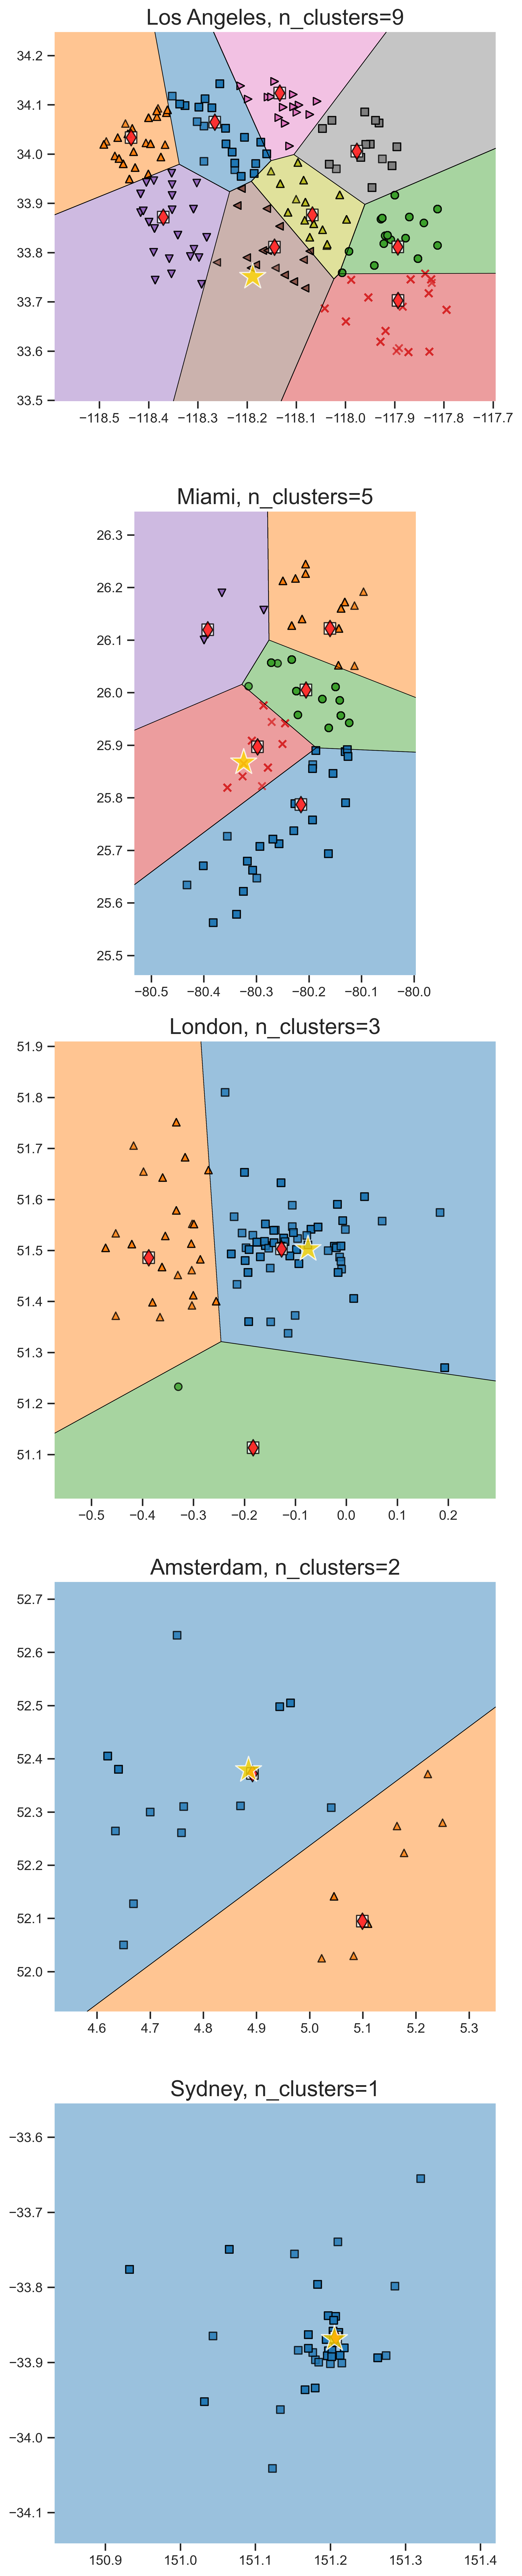

In [26]:
# отрисовка диаграмм кластеризации
plotter(report)

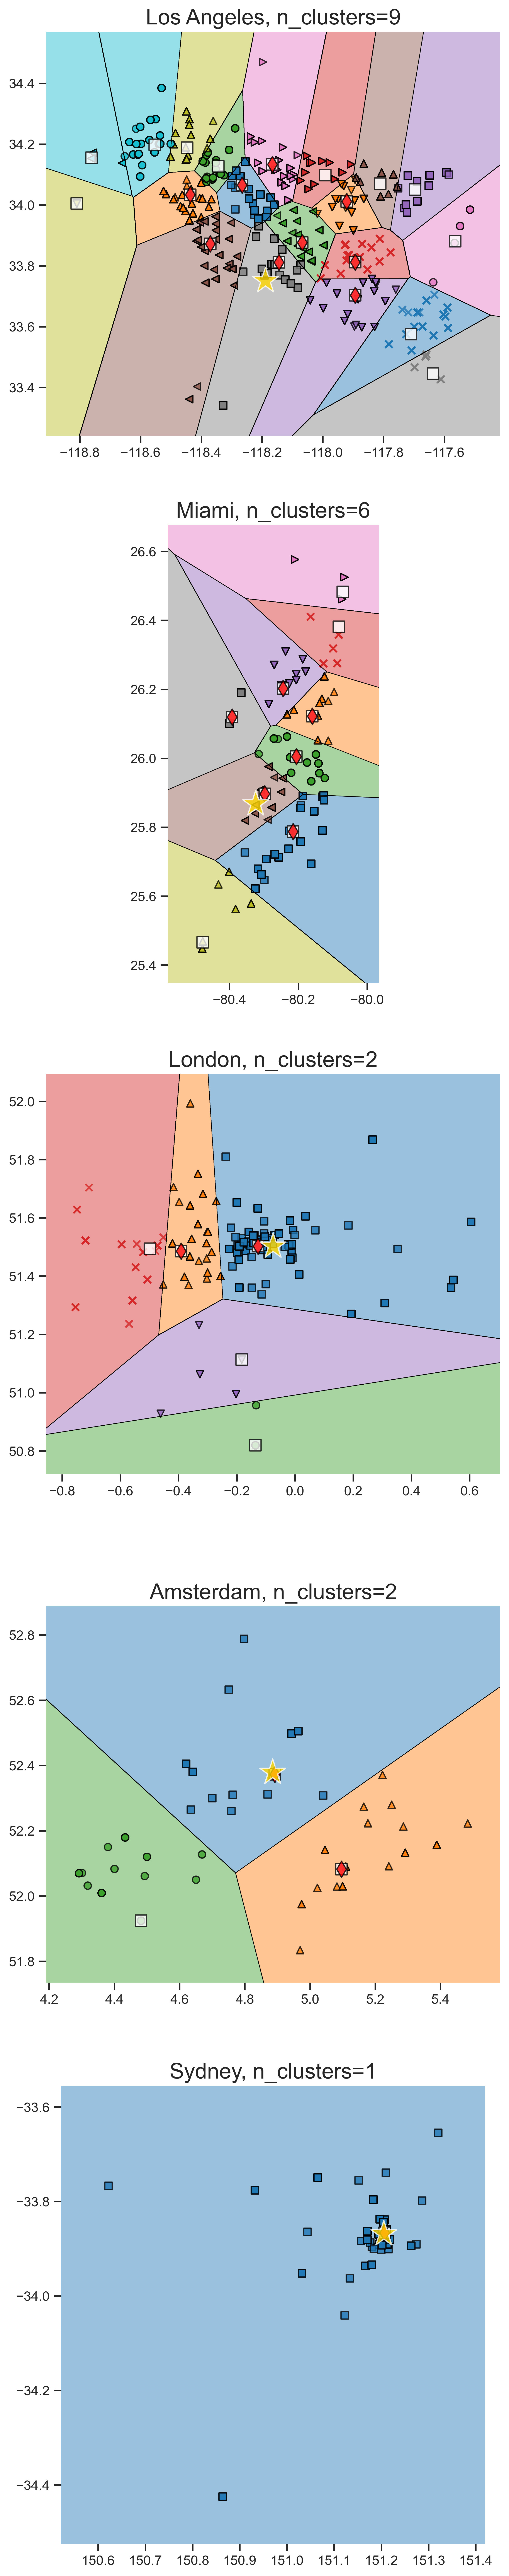

In [27]:
# проверка:
# появление новых центров - без баннеров - при радиусе больше 45 км
plotter(clustering_report(radius=80))

***